# Japanese Equity Data - Feature Engineering

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import talib

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('white')

In [4]:
idx = pd.IndexSlice

## Get Data

### Stooq Japanese Equity data 2014-2019

In [5]:
DATA_DIR = Path('..', 'data')

In [6]:
prices = (pd.read_hdf(DATA_DIR / 'assets.h5', 'stooq/jp/tse/stocks/prices')
          .loc[idx[:, '2010': '2019'], :]
          .loc[lambda df: ~df.index.duplicated(), :])

In [7]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7157801 entries, ('1301.JP', Timestamp('2010-01-04 00:00:00')) to ('9997.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    7157801 non-null  float64
 1   high    7157801 non-null  float64
 2   low     7157801 non-null  float64
 3   close   7157801 non-null  float64
 4   volume  7157801 non-null  float64
dtypes: float64(5)
memory usage: 300.7+ MB


In [8]:
before = len(prices.index.unique('ticker').unique())

### Remove symbols with missing values

In [9]:
prices = (prices.unstack('ticker')
        .sort_index()
        .ffill(limit=5)
        .dropna(axis=1, how='all')
        .stack('ticker')
        .swaplevel())
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7385476 entries, ('1301.JP', Timestamp('2010-01-04 00:00:00')) to ('9997.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    7385476 non-null  float64
 1   high    7385476 non-null  float64
 2   low     7385476 non-null  float64
 3   close   7385476 non-null  float64
 4   volume  7385476 non-null  float64
dtypes: float64(5)
memory usage: 310.1+ MB


In [10]:
after = len(prices.index.unique('ticker').unique())
print(f'Before: {before:,.0f} after: {after:,.0f}')

Before: 3,491 after: 3,491


### Keep most traded symbols

In [11]:
dv = prices.close.mul(prices.volume)

In [12]:
dv = prices.close.mul(prices.volume)
keep = dv.groupby('ticker').median().nlargest(1000).index.tolist()    # 选取price*volume 最大的1000只股票

In [13]:
prices = prices.loc[idx[keep, :], :]
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2061587 entries, ('9984.JP', Timestamp('2010-01-04 00:00:00')) to ('6958.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2061587 non-null  float64
 1   high    2061587 non-null  float64
 2   low     2061587 non-null  float64
 3   close   2061587 non-null  float64
 4   volume  2061587 non-null  float64
dtypes: float64(5)
memory usage: 86.7+ MB


## Feature Engineering

### Compute period returns

In [14]:
intervals = [1, 5, 10, 21, 63]

In [15]:
returns = []
by_ticker = prices.groupby(level='ticker').close
for t in intervals:
    returns.append(by_ticker.pct_change(t).to_frame(f'ret_{t}'))
returns = pd.concat(returns, axis=1)

In [16]:
returns.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2061587 entries, ('9984.JP', Timestamp('2010-01-04 00:00:00')) to ('6958.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   ret_1   2060587 non-null  float64
 1   ret_5   2056594 non-null  float64
 2   ret_10  2051628 non-null  float64
 3   ret_21  2040838 non-null  float64
 4   ret_63  1999863 non-null  float64
dtypes: float64(5)
memory usage: 86.7+ MB


### Remove outliers

In [17]:
max_ret_by_sym = returns.groupby(level='ticker').max()

In [18]:
percentiles = [0.001, .005, .01, .025, .05, .1]
percentiles += [1-p for p in percentiles]
max_ret_by_sym.describe(percentiles=sorted(percentiles)[6:])    # 最大值的百分位数

,ret_1,ret_5,ret_10,ret_21,ret_63
count,1000.000000,997.000000,987.000000,979.000000,971.000000
mean,0.171639,0.341959,0.452535,0.590765,0.963257
std,0.202059,0.341845,0.510376,0.679661,1.297571
min,-0.044163,-0.120358,-0.182045,0.130010,-0.220721
50%,0.150472,0.251798,0.307718,0.394127,0.642953
90%,0.253469,0.610849,0.777206,1.000450,1.728363
95%,0.292695,0.816944,1.178578,1.435614,2.435503
97.5%,0.349383,1.098277,1.740925,2.295333,3.688869
99%,0.387721,1.433700,2.758244,3.563731,5.356266
99.5%,0.486164,1.719129,3.443252,5.439052,7.035241


In [19]:
quantiles = max_ret_by_sym.quantile(.95)
to_drop = []
for ret, q in quantiles.items():
    to_drop.extend(max_ret_by_sym[max_ret_by_sym[ret]>q].index.tolist())    # to_drop: 最大收益在95%分位数之后的数据

In [20]:
to_drop = pd.Series(to_drop).value_counts()
to_drop = to_drop[to_drop > 1].index.tolist()
len(to_drop)

59

In [21]:
prices = prices.drop(to_drop, level='ticker')
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1944198 entries, ('9984.JP', Timestamp('2010-01-04 00:00:00')) to ('6958.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    1944198 non-null  float64
 1   high    1944198 non-null  float64
 2   low     1944198 non-null  float64
 3   close   1944198 non-null  float64
 4   volume  1944198 non-null  float64
dtypes: float64(5)
memory usage: 81.8+ MB


### Calculate relative return percentiles

In [22]:
returns = []
by_sym = prices.groupby(level='ticker').close

In [23]:
t = intervals[0]

In [24]:
ret = by_sym.pct_change(t)

In [25]:
a = ret.groupby(level='date').apply(lambda x: pd.qcut(x, q=20, labels=False, duplicates='drop'))

In [26]:
a

ticker   date      
9984.JP  2010-01-04     NaN
         2010-01-05    10.0
         2010-01-06     7.0
         2010-01-07    13.0
         2010-01-08     2.0
                       ... 
6958.JP  2019-12-24     5.0
         2019-12-25     4.0
         2019-12-26    18.0
         2019-12-27    17.0
         2019-12-30    17.0
Name: close, Length: 1944198, dtype: float64

In [27]:
returns = []
by_sym = prices.groupby(level='ticker').close
for t in intervals:
    ret = by_sym.pct_change(t)
    rel_perc = (ret.groupby(level='date')
             .apply(lambda x: pd.qcut(x, q=20, labels=False, duplicates='drop')))    # 计算收益，然后对收益进行分箱
    returns.extend([ret.to_frame(f'ret_{t}'), rel_perc.to_frame(f'ret_rel_perc_{t}')])
returns = pd.concat(returns, axis=1)

In [28]:
returns

ret_1  ret_rel_perc_1     ret_5  ret_rel_perc_5  \
ticker  date                                                             
9984.JP 2010-01-04       NaN             NaN       NaN             NaN   
        2010-01-05  0.001850            10.0       NaN             NaN   
        2010-01-06  0.001371             7.0       NaN             NaN   
        2010-01-07  0.005950            13.0       NaN             NaN   
        2010-01-08 -0.007276             2.0       NaN             NaN   
...                      ...             ...       ...             ...   
6958.JP 2019-12-24 -0.004543             5.0  0.004601            15.0   
        2019-12-25 -0.013723             4.0 -0.019704             6.0   
        2019-12-26  0.023185            18.0 -0.004518             9.0   
        2019-12-27  0.016614            17.0  0.005982            12.0   
        2019-12-30  0.001483            17.0  0.022763            17.0   

                      ret_10  ret_rel_perc_10    ret_21  ret_rel_perc_21  \
ticker  date                                                               
9984.JP 2010-01-04       NaN              NaN       NaN              NaN   
        2010-01-05       NaN              NaN       NaN              NaN   
        2010-01-06       NaN              NaN       NaN              NaN   
        2010-01-07       NaN              NaN       NaN              NaN   
        2010-01-08       NaN              NaN       NaN              NaN   
...                      ...              ...       ...              ...   
6958.JP 2019-12-24 -0.007565              9.0 -0.019424              5.0   
        2019-12-25 -0.003076             10.0 -0.037204              4.0   
        2019-12-26  0.037623             16.0 -0.016343              6.0   
        2019-12-27  0.033790             16.0  0.018149             10.0   
        2019-12-30  0.025870             16.0  0.043336             15.0   

                      ret_63  ret_rel_perc_63  
ticker  date                                   
9984.JP 2010-01-04       NaN              NaN  
        2010-01-05       NaN              NaN  
        2010-01-06       NaN              NaN  
        2010-01-07       NaN              NaN  
        2010-01-08       NaN              NaN  
...                      ...              ...  
6958.JP 2019-12-24  0.104375             11.0  
        2019-12-25  0.091053             11.0  
        2019-12-26  0.131624             13.0  
        2019-12-27  0.140675             13.0  
        2019-12-30  0.138515             14.0  

[1944198 rows x 10 columns]

### Technical Indicators

#### Percentage Price Oscillator
价格震荡百分比指标

In [29]:
ppo = prices.groupby(level='ticker').close.apply(talib.PPO).to_frame('PPO')

In [30]:
ppo

PPO
ticker  date                
9984.JP 2010-01-04       NaN
        2010-01-05       NaN
        2010-01-06       NaN
        2010-01-07       NaN
        2010-01-08       NaN
...                      ...
6958.JP 2019-12-24 -0.919434
        2019-12-25 -0.971453
        2019-12-26 -0.843637
        2019-12-27 -0.541059
        2019-12-30 -0.133704

[1944198 rows x 1 columns]

#### Normalized Average True Range
归一化波动幅度均值

In [31]:
natr = prices.groupby(level='ticker', group_keys=False).apply(lambda x: talib.NATR(x.high, x.low, x.close)).to_frame('NATR')

#### Relative Strength Indicator
相对强弱指数

In [32]:
rsi = prices.groupby(level='ticker').close.apply(talib.RSI).to_frame('RSI')

#### Bollinger Bands
布林线指标

In [33]:
def get_bollinger(x):
    u, m, l = talib.BBANDS(x)
    return pd.DataFrame({'u': u, 'm': m, 'l': l})

In [34]:
bbands = prices.groupby(level='ticker').close.apply(get_bollinger)

### Combine Features

In [35]:
data = pd.concat([prices, returns, ppo, natr, rsi, bbands], axis=1)

In [36]:
data['bbl'] = data.close.div(data.l)
data['bbu'] = data.u.div(data.close)
data = data.drop(['u', 'm', 'l'], axis=1)

In [37]:
data.bbu.corr(data.bbl, method='spearman')

-0.15769181487634276

### Plot Indicators for randomly sample ticker

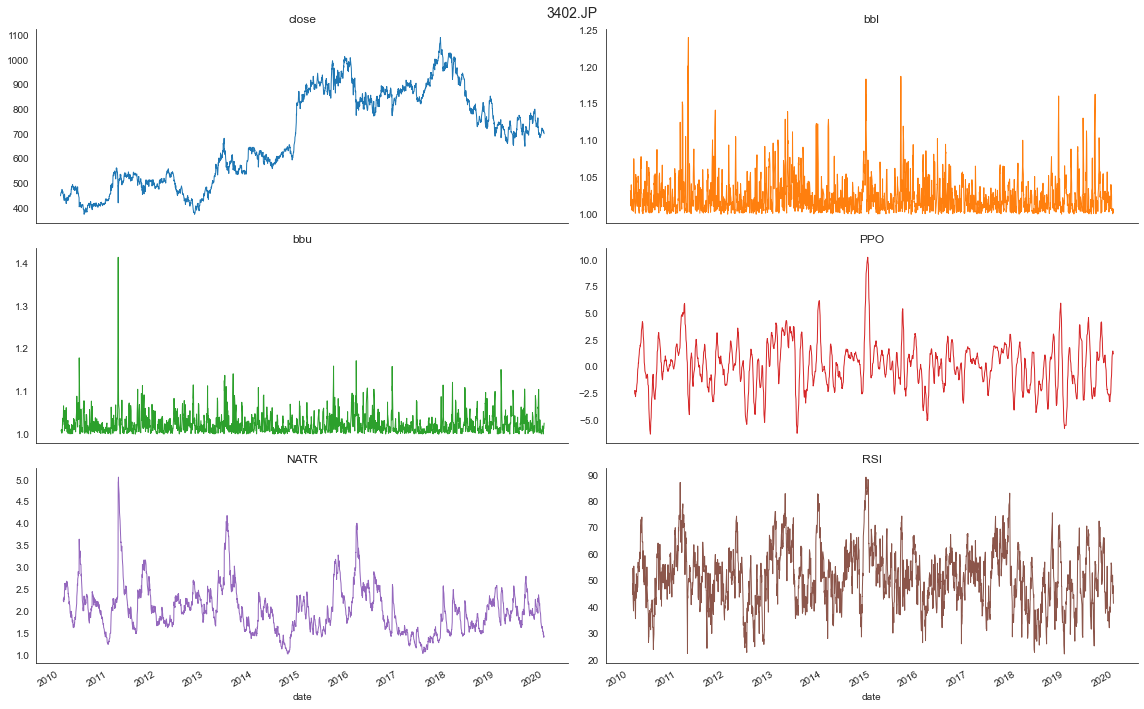

In [38]:
indicators = ['close', 'bbl', 'bbu', 'PPO', 'NATR', 'RSI']
ticker = np.random.choice(data.index.get_level_values('ticker'))
(data.loc[idx[ticker, :], indicators].reset_index('ticker', drop=True)
 .plot(lw=1, subplots=True, figsize=(16, 10), title=indicators, layout=(3, 2), legend=False))
plt.suptitle(ticker, fontsize=14)
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=.95)

In [39]:
data = data.drop(prices.columns, axis=1)

### Create time period indicators

In [40]:
dates = data.index.get_level_values('date')
data['weekday'] = dates.weekday
data['month'] = dates.month
data['year'] = dates.year

## Compute forward returns

In [41]:
outcomes = []
by_ticker = data.groupby('ticker')
for t in intervals:
    k = f'fwd_ret_{t:02}'
    outcomes.append(k)
    data[k] = by_ticker[f'ret_{t}'].shift(-t)

In [42]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1944198 entries, ('1332.JP', Timestamp('2010-01-04 00:00:00')) to ('9989.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   ret_1            1943257 non-null  float64
 1   ret_rel_perc_1   1943257 non-null  float64
 2   ret_5            1939500 non-null  float64
 3   ret_rel_perc_5   1939500 non-null  float64
 4   ret_10           1934829 non-null  float64
 5   ret_rel_perc_10  1934829 non-null  float64
 6   ret_21           1924679 non-null  float64
 7   ret_rel_perc_21  1924679 non-null  float64
 8   ret_63           1886140 non-null  float64
 9   ret_rel_perc_63  1886140 non-null  float64
 10  PPO              1920995 non-null  float64
 11  NATR             1931127 non-null  float64
 12  RSI              1931127 non-null  float64
 13  bbl              1940438 non-null  float64
 14  bbu              1940438 non-nul

In [43]:
data.to_hdf('data.h5', 'stooq/japan/equities')